In [ ]:
# Install dependencies
!pip install tensorflow

In [38]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image, ImageDraw
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [6]:
# Generate data paths with labels
data_dir = './assets/Drug Vision/Data Combined'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,./assets/Drug Vision/Data Combined/Decolgen/00...,Decolgen
1,./assets/Drug Vision/Data Combined/Decolgen/00...,Decolgen
2,./assets/Drug Vision/Data Combined/Decolgen/00...,Decolgen
3,./assets/Drug Vision/Data Combined/Decolgen/00...,Decolgen
4,./assets/Drug Vision/Data Combined/Decolgen/00...,Decolgen
...,...,...
9995,./assets/Drug Vision/Data Combined/Medicol/000...,Medicol
9996,./assets/Drug Vision/Data Combined/Medicol/000...,Medicol
9997,./assets/Drug Vision/Data Combined/Medicol/000...,Medicol
9998,./assets/Drug Vision/Data Combined/Medicol/000...,Medicol


In [8]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [9]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1200 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.


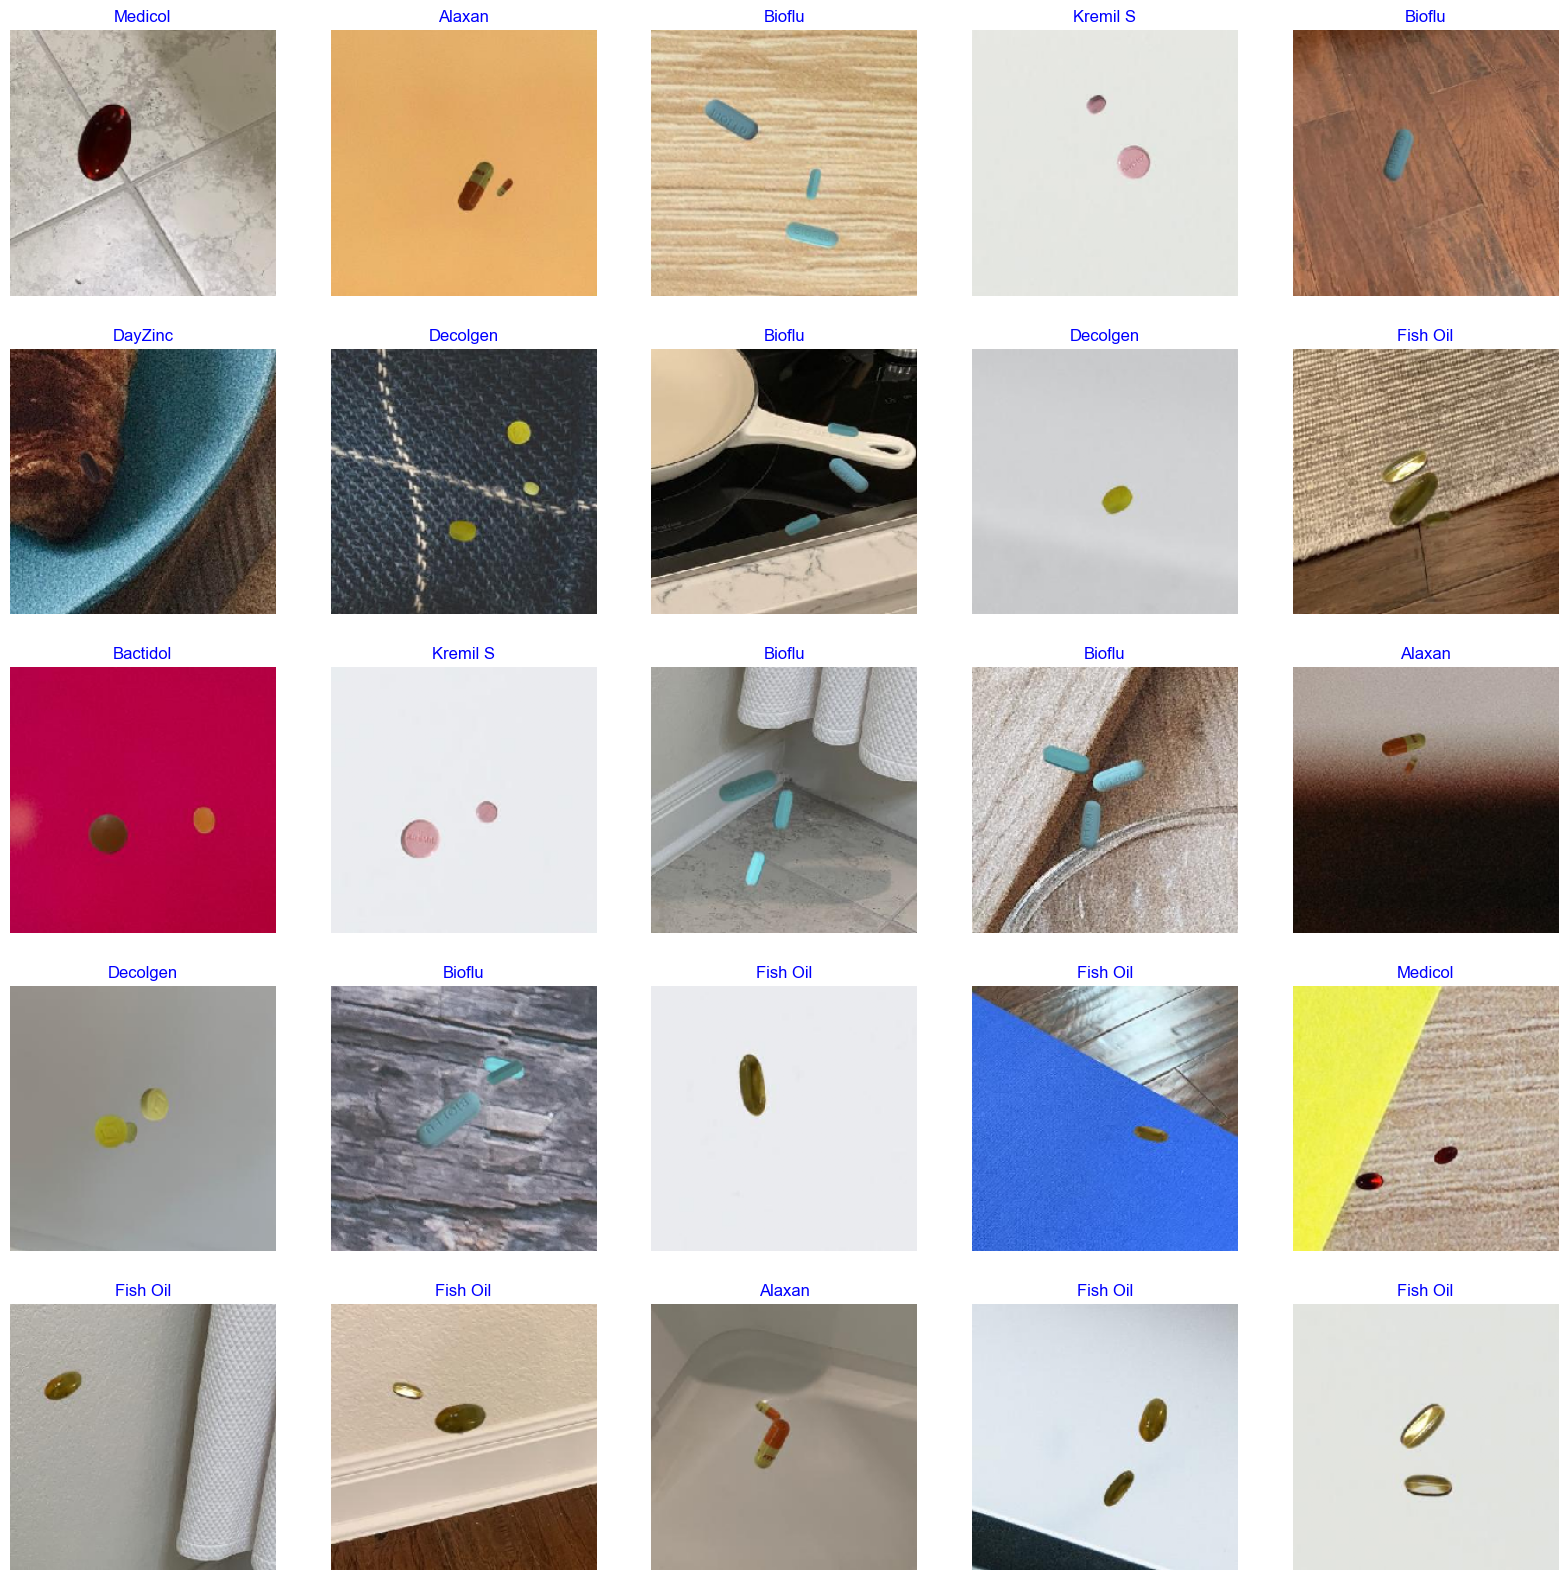

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 10s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 11185721 (42.67 MB)
Trainable params: 1109

In [12]:
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
125/125 [==============================] - 14533s 117s/step - loss: 6.7762 - accuracy: 0.8450 - val_loss: 4.9989 - val_accuracy: 0.9733
Epoch 2/20
125/125 [==============================] - 8959s 72s/step - loss: 3.8604 - accuracy: 0.9868 - val_loss: 2.9690 - val_accuracy: 0.9933
Epoch 3/20
125/125 [==============================] - 7534s 61s/step - loss: 2.3796 - accuracy: 0.9946 - val_loss: 1.8237 - val_accuracy: 0.9950
Epoch 4/20
125/125 [==============================] - 17693s 143s/step - loss: 1.4802 - accuracy: 0.9958 - val_loss: 1.1264 - val_accuracy: 0.9983
Epoch 5/20
125/125 [==============================] - 2818s 22s/step - loss: 0.9397 - accuracy: 0.9973 - val_loss: 0.7206 - val_accuracy: 0.9983
Epoch 6/20
125/125 [==============================] - 2800s 22s/step - loss: 0.6212 - accuracy: 0.9981 - val_loss: 0.4868 - val_accuracy: 0.9967
Epoch 7/20
125/125 [==============================] - 2895s 23s/step - loss: 0.4438 - accuracy: 0.9975 - val_loss: 0.3510 - va

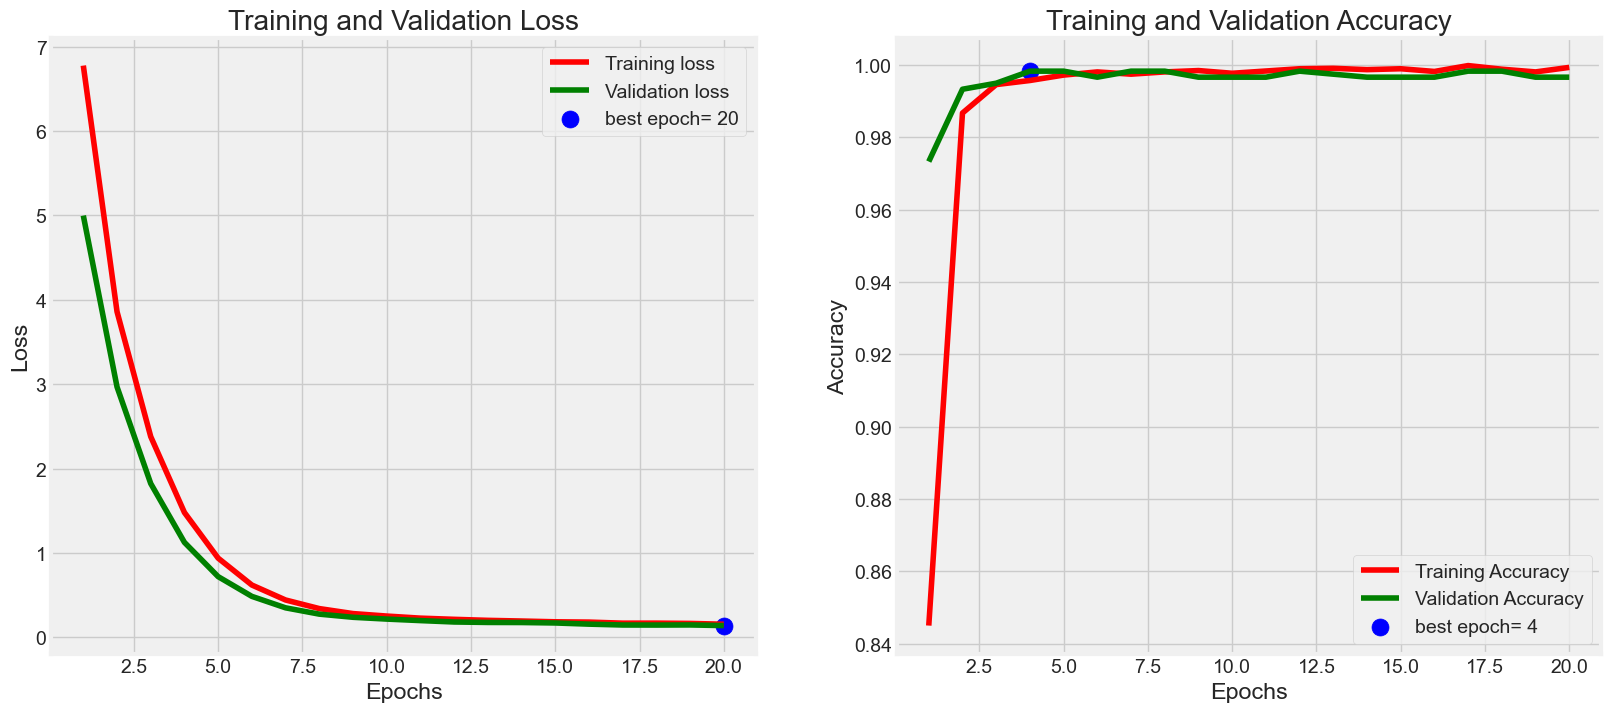

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 20s 2s/step - loss: 0.1486 - accuracy: 0.9962
Train Loss:  0.13084332644939423
Train Accuracy:  1.0
--------------------
Validation Loss:  0.14584290981292725
Validation Accuracy:  0.995312511920929
--------------------
Test Loss:  0.14864081144332886
Test Accuracy:  0.9962499737739563


In [16]:
# save the model
model.save('model1.keras')

In [17]:
# save training history (run if necessary)
import json

# Assuming 'history' is your History object obtained from model.fit()
# Convert history to a dictionary
history_dict = history.history

# Save to a JSON file
with open('training_history.json', 'w') as json_file:
    json.dump(history_dict, json_file)


In [ ]:
# history loading (run if necessary)
import json

# Load history from a JSON file
with open('training_history.json', 'r') as json_file:
    loaded_history = json.load(json_file)

# Now 'loaded_history' is a dictionary containing the training history


## Get predictions

In [18]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

### Confusion Matrix

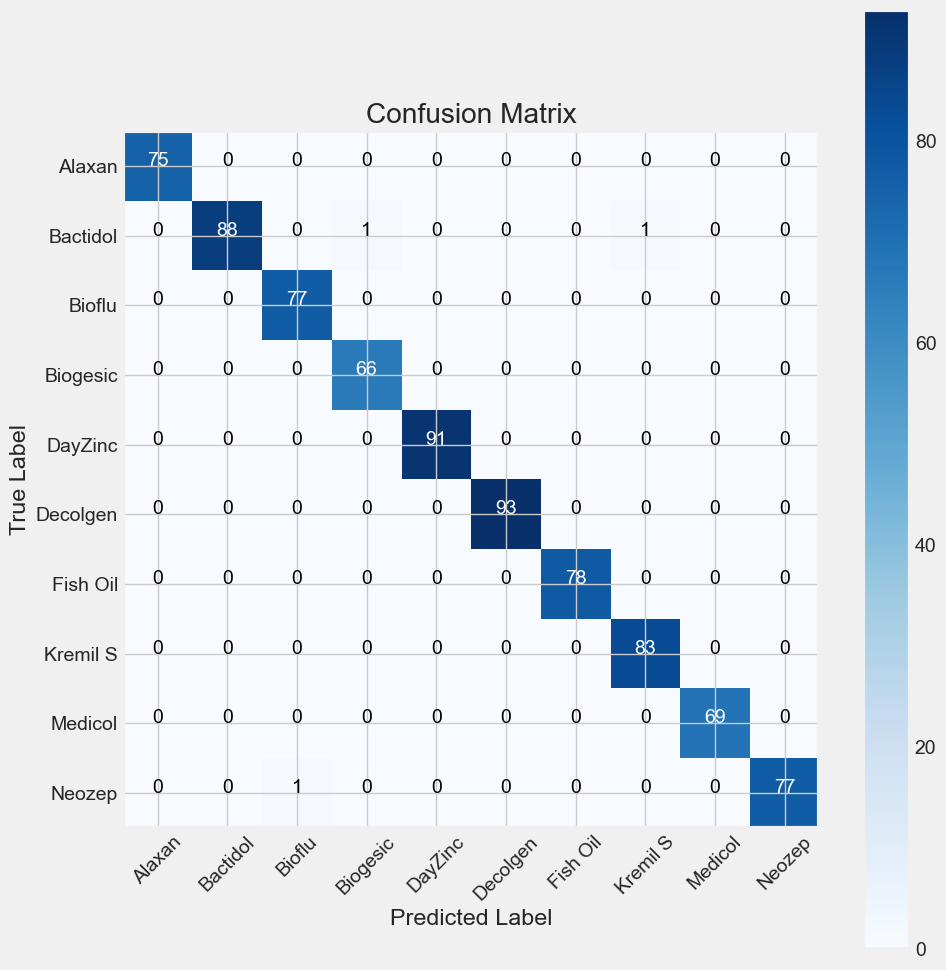

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Alaxan       1.00      1.00      1.00        75
    Bactidol       1.00      0.98      0.99        90
      Bioflu       0.99      1.00      0.99        77
    Biogesic       0.99      1.00      0.99        66
     DayZinc       1.00      1.00      1.00        91
    Decolgen       1.00      1.00      1.00        93
    Fish Oil       1.00      1.00      1.00        78
    Kremil S       0.99      1.00      0.99        83
     Medicol       1.00      1.00      1.00        69
      Neozep       1.00      0.99      0.99        78

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [21]:
# save the model
model.save('Malaria Cells.h5')

In [32]:
loaded_model = tf.keras.models.load_model('models/model1.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Implementation

### Single Search, image similar to training

In [33]:
image_path = 'assets/ImageClassesCombinedWithCOCOAnnotations/images_raw/00000011.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 833ms/step
Decolgen


### Real-case scenario: Picture